In [3]:
import csv
import glob
import os
import h5py
import cv2
import numpy as np
import torch
import trimesh
from PIL import Image
from pathlib import Path
import sys
from argparse import ArgumentParser
from datetime import datetime
import torch
import torch.multiprocessing as mp
import yaml
import numpy as np
from munch import munchify
import wandb


import sys
sys.path.append("D:/gs-localization/gaussian_splatting")
sys.path.append("D:/gs-localization")
from tools.gaussian_model import GaussianModel
from gaussian_splatting.utils.system_utils import mkdir_p
from tools.config_utils import load_config, set_config, update_recursive
from tools.dataset import v2_360_Dataset
from tools import read_write_model
from tools.eval_utils import rotation_error, translation_error

def set_config(tr_dirs, config):
    cameras, _, _ = read_write_model.read_model(tr_dirs, ".bin")
    config["Dataset"]["dataset_path"] = tr_dirs
    print(cameras)
    config["Dataset"]["Calibration"]["fx"] = cameras[1][4][0]
    config["Dataset"]["Calibration"]["fy"] = cameras[1][4][0]
    config["Dataset"]["Calibration"]["cx"] = cameras[1][4][1]
    config["Dataset"]["Calibration"]["cy"] = cameras[1][4][2]
    config["Dataset"]["Calibration"]["width"] = cameras[1][2]
    config["Dataset"]["Calibration"]["height"] = cameras[1][3]
    return config
    
with open("configs/mono/tum/fr3_office.yaml", "r") as f:
    cfg_special = yaml.full_load(f)

inherit_from = "configs/mono/tum/base_config.yaml"

if inherit_from is not None:
    cfg = load_config(inherit_from)
else:
    cfg = dict()

# merge per dataset cfg. and main cfg.
config = update_recursive(cfg, cfg_special)
config = cfg
    
data_folder = "D:/gs-localization/datasets/nerf_llff_data"
scene = "fern"
tr_dirs = Path(data_folder) / scene / "train_views/triangulated"
config = set_config(tr_dirs, config)

Model = GaussianModel(3, config)
#Model.load_ply("C:/Users/27118/Desktop/master_project/RaDe-GS/output/26b22380-1/point_cloud/iteration_30000/point_cloud.ply")
#Model.load_ply("D:/gaussian-splatting/output/73bdba8c-0/point_cloud/iteration_25000/point_cloud.ply")
Model.load_ply(f"D:/gs-localization/output/nerf_llff_data/{scene}/gs_map_test/iteration_30000/point_cloud.ply")

model_params = munchify(config["model_params"])
pipeline_params = munchify(config["pipeline_params"])
data_folder = "D:/gs-localization/datasets/nerf_llff_data"
dataset = v2_360_Dataset(model_params, model_params.source_path, config, data_folder, scene)
bg_color = [0, 0, 0] 
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

from tools.config_utils import load_config, update_recursive
from tools import read_write_model
from tools.gaussian_model import GaussianModel
from tools import render
from tools.camera_utils import Camera
from tools.descent_utils import get_loss_tracking
from tools.pose_utils import update_pose
from tools.graphics_utils import getProjectionMatrix2

projection_matrix = getProjectionMatrix2(
    znear=0.01,
    zfar=100.0,
    fx=dataset.fx,
    fy=dataset.fy,
    cx=dataset.cx,
    cy=dataset.cy,
    W=dataset.width,
    H=dataset.height,
).transpose(0, 1)
projection_matrix = projection_matrix.to(device="cuda:0")

config["Training"]["opacity_threshold"] = 0.5
config["Training"]["edge_threshold"] = 0.8
from time import time

def gradient_decent(viewpoint, config, initial_R, initial_T):

    viewpoint.update_RT(initial_R, initial_T)
    
    opt_params = []
    opt_params.append(
        {
            "params": [viewpoint.cam_rot_delta],
            "lr": 0.0001,
            "name": "rot_{}".format(viewpoint.uid),
        }
    )
    opt_params.append(
        {
            "params": [viewpoint.cam_trans_delta],
            "lr": 0.001,
            "name": "trans_{}".format(viewpoint.uid),
        }
    )
    opt_params.append(
        {
            "params": [viewpoint.exposure_a],
            "lr": 0.001,
            "name": "exposure_a_{}".format(viewpoint.uid),
        }
    )
    opt_params.append(
        {
            "params": [viewpoint.exposure_b],
            "lr": 0.001,
            "name": "exposure_b_{}".format(viewpoint.uid),
        }
    )
    

    pose_optimizer = torch.optim.Adam(opt_params)
    
    for tracking_itr in range(50):
        
        render_pkg = render(
            viewpoint, Model, pipeline_params, background
        )
        
        image, depth, opacity = (
            render_pkg["render"],
            render_pkg["depth"],
            render_pkg["opacity"],
        )
          
        pose_optimizer.zero_grad()
        
        loss_tracking = get_loss_tracking(
            config, image, depth, opacity, viewpoint
        )
        loss_tracking.backward()
        
    
        with torch.no_grad():
            pose_optimizer.step()
            converged = update_pose(viewpoint, converged_threshold=1e-5)
    
        if converged:
            break
             
    return viewpoint.R, viewpoint.T, render_pkg

import numpy as np
from collections import defaultdict

class Transformation:
    def __init__(self, R=None, T=None):
        self.R = R
        self.T = T

test_infos = defaultdict(Transformation)

def quat_to_rotmat(qvec):
    qvec = np.array(qvec, dtype=float)
    w, x, y, z = qvec
    R = np.array([
        [1 - 2*y**2 - 2*z**2, 2*x*y - 2*z*w, 2*x*z + 2*y*w],
        [2*x*y + 2*z*w, 1 - 2*x**2 - 2*z**2, 2*y*z - 2*x*w],
        [2*x*z - 2*y*w, 2*y*z + 2*x*w, 1 - 2*x**2 - 2*y**2]
    ])
    return R

with open(f"D:/gs-localization/output/nerf_llff_data/{scene}/results_sparse.txt", "r") as f:
    for line in f:
        parts = line.strip().split()
        name = parts[0]
        qvec = list(map(float, parts[1:5]))
        tvec = list(map(float, parts[5:8]))

        R = quat_to_rotmat(qvec)
        T = np.array(tvec)

        test_infos[name].R = R
        test_infos[name].T = T


def create_mask(mkpts_lst, width, height, k):
    # 初始化 mask，全为 False
    mask = np.zeros((height, width), dtype=bool)
    
    # 计算 k 的半径
    half_k = k // 2
    
    # 遍历所有点
    for pt in mkpts_lst:
        x, y = int(pt[0]), int(pt[1])
        
        # 计算 k*k 区域的边界
        x_min = max(0, x - half_k)
        x_max = min(width, x + half_k + 1)
        y_min = max(0, y - half_k)
        y_max = min(height, y + half_k + 1)
        
        # 设置 mask 中的 k*k 区域为 True
        mask[y_min:y_max, x_min:x_max] = True
    
    # 形状为 (1, height, width)
    mask = mask[np.newaxis, :, :]
    
    return mask

rot_errors = []
trans_errors = []

file = h5py.File(f'D:/gs-localization/output/nerf_llff_data/{scene}/feats-superpoint-n4096-r1024.h5', 'r')

for i, image in enumerate(test_infos):
    viewpoint = Camera.init_from_dataset(dataset, i, projection_matrix)

    viewpoint.compute_grad_mask(config)

    group = file[image] 
    keypoints = group['keypoints'][group['scores'][:]>0.2]  
    mask = create_mask(mkpts_lst=keypoints, width=dataset.width, height=dataset.height, k=20)
    viewpoint.grad_mask = viewpoint.grad_mask | torch.tensor(mask).to("cuda:0")

    viewpoint.grad_mask[:,:20,:] = 0; viewpoint.grad_mask[:,-20:,:] = 0
    viewpoint.grad_mask[:,:,:50] = 0; viewpoint.grad_mask[:,:,-50:] = 0

    config["Training"]["monocular"] = True

    initial_R = torch.tensor(test_infos[image].R)
    initial_T = torch.tensor(test_infos[image].T).squeeze()

    rotation_matrix, translation_vector, render_pkg = gradient_decent(viewpoint, config, initial_R, initial_T)
    
    #rotation_matrix, translation_vector = initial_R, initial_T
    
    rot_error = rotation_error(rotation_matrix.cpu().numpy(), viewpoint.R_gt.cpu().numpy())
    trans_error = translation_error(translation_vector.reshape(3,1).cpu().numpy(), viewpoint.T_gt.reshape(3,1).cpu().numpy())

    print(image, rot_error, trans_error)
    rot_errors.append(rot_error)
    trans_errors.append(trans_error)

file.close()



{1: Camera(id=1, model='SIMPLE_PINHOLE', width=1008, height=756, params=array([815.13158322, 504.        , 378.        ]))}
IMG_4026.JPG 0.039068769007568505 0.02003224079182067
IMG_4028.JPG 0.06803457207782335 0.035911555364705125
IMG_4029.JPG 0.05170683844388161 0.03522237061741756


KeyboardInterrupt: 

In [20]:
viewpoint1 = Camera.init_from_dataset(dataset, 5, projection_matrix)
viewpoint1.update_RT(viewpoint1.R_gt, viewpoint1.T_gt)
render_pkg1 = render(
            viewpoint1, Model, pipeline_params, background
        )


viewpoint2 = Camera.init_from_dataset(dataset, 6, projection_matrix)
viewpoint2.update_RT(viewpoint2.R_gt, viewpoint2.T_gt)
render_pkg2 = render(
            viewpoint2, Model, pipeline_params, background
        )

Tcam1 = torch.eye(4)  # Create a 4x4 identity matrix
Tcam1[:3, :3] = viewpoint1.R_gt  # Set the top-left 3x3 block as the rotation matrix
Tcam1[:3, 3] = viewpoint1.T_gt   # Set the top-right 3x1 block as the translation vector

Tcam2 = torch.eye(4)  # Create a 4x4 identity matrix
Tcam2[:3, :3] = viewpoint2.R_gt  # Set the top-left 3x3 block as the rotation matrix
Tcam2[:3, 3] = viewpoint2.T_gt   # Set the top-right 3x1 block as the translation vector

img2 = render_pkg2["render"]
depth_map = render_pkg2["depth"]

K_np = np.array([
    [dataset.fx, 0,  dataset.cx],
    [0,  dataset.fy, dataset.cy],
    [0,  0,  1]
], dtype=np.float32)

# Convert the numpy intrinsic matrix to a PyTorch tensor
K = torch.tensor(K_np, dtype=torch.float32)



In [21]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


for i in range(1):
    T12 = torch.inverse(Tcam1) @ Tcam2  # Shape (4, 4)
    H, W = depth_map.shape[1:]  # Extract height and width
    y, x = torch.meshgrid(torch.arange(0, H), torch.arange(0, W), indexing='ij')
    ones = torch.ones_like(x)
    pixel_coords = torch.stack([x, y, ones], dim=0).float()  # Shape: (3, H, W)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    depth_map = depth_map.to(device)
    K = K.to(device)
    pixel_coords = pixel_coords.to(device)
    ones = ones.to(device)
    T12 = T12.to(device)
    
    pixel_coords = pixel_coords.reshape(3, -1)  # Shape: (3, H*W)
    depth2_flat = depth_map.view(-1)  # Flatten the depth map: Shape (H*W)
    
    K_inv = torch.inverse(K)  # Shape: (3, 3)
    cam2_3D = K_inv @ pixel_coords * depth2_flat  # Shape: (3, H*W)
    cam2_3D = torch.cat([cam2_3D, ones.view(1, -1)], dim=0)  # Shape (4, H*W) in homogeneous coords
    
    cam1_3D = torch.inverse(T12) @ cam2_3D  # Shape (4, H*W)
    cam1_3D = cam1_3D[:3, :]  # Discard the homogeneous coordinate
    
    cam1_2D = K @ cam1_3D  # Shape: (3, H*W)
    # Extract the third row (the z values for normalization) without modifying the original tensor
    z_vals = cam1_2D[2, :].clone()  # Shape: (H*W), clone to ensure no memory conflict
    # Normalize the first two rows of cam1_2D by the third row (z values)
    cam1_2D = cam1_2D[:2, :] / z_vals  # Shape: (2, H*W)
    # Reshape back to (2, H, W)
    cam1_2D = cam1_2D.view(2, H, W)
    
    # Normalize pixel coordinates between -1 and 1 for grid sampling
    cam1_2D[0, :, :] = (cam1_2D[0, :, :] / (W - 1)) * 2 - 1  # Normalize x
    cam1_2D[1, :, :] = (cam1_2D[1, :, :] / (H - 1)) * 2 - 1  # Normalize y
    
    # Stack coordinates for grid_sample
    grid = torch.stack([cam1_2D[0], cam1_2D[1]], dim=-1)  # Shape: (H, W, 2)
    
    # Use grid_sample to sample img2 at the new coordinates
    img2_warped_to_cam1 = F.grid_sample(img2.unsqueeze(0), grid.unsqueeze(0), align_corners=True)
    img2_warped_to_cam1 = img2_warped_to_cam1.squeeze(0)  # Shape: (C, H, W)
    


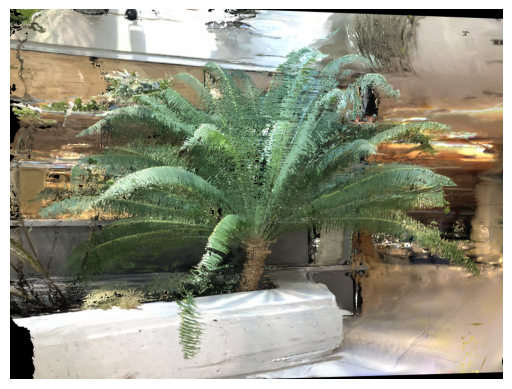

In [22]:
tensor_image = img2_warped_to_cam1

# 将 Tensor 转为 NumPy 数组
if torch.is_tensor(tensor_image):
    tensor_image = tensor_image.detach().cpu().numpy()

# 检查 Tensor 的形状是否需要转置
if tensor_image.shape[0] == 3:  # 如果形状是 (C, H, W)，转为 (H, W, C)
    tensor_image = np.transpose(tensor_image, (1, 2, 0))

# 如果是 float 类型，且值在 [0, 1] 之间，将其转为 [0, 255]
if tensor_image.dtype == np.float32 or tensor_image.dtype == np.float64:
    tensor_image = np.clip(tensor_image * 255, 0, 255).astype(np.uint8)

# 显示图像
plt.imshow(tensor_image)
plt.axis('off')  # 不显示坐标轴
plt.show()


In [25]:
import numpy as np

# 假设 tensor_image 是形状为 (H, W, 3) 的 NumPy 数组
# 判断每个像素是否为黑色，黑色像素满足 R=0, G=0, B=0
black_pixels = np.all(tensor_image == 0, axis=-1)

# 计算黑色像素的数量
black_pixel_count = np.sum(black_pixels)

print(f"黑色像素的数量: {black_pixel_count}")


黑色像素的数量: 17391
